In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import torch
import torchvision
import torchvision.transforms as transforms
from IPython import display

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zipfile as zf
import io

In [ ]:

# # if dataset zipped
zf = zf.ZipFile("denoising2.zip", 'r')
zf.extractall()

In [ ]:
device = torch.device('cuda:0')


In [2]:
class IBlock(nn.Module):
    def __init__(self, out_channels,in_channels=None):
        """
        Intermediate block in UNet
        Args:
          in_channels (int):  Number of input channels.
        """
        super(IBlock, self).__init__()
        # variable number of in_channels, if different than out_channels specify.
        self.in_channels=in_channels if in_channels else out_channels 
        self.unit1 = nn.Sequential(nn.Conv2d(in_channels=self.in_channels, 
                                             out_channels=out_channels,
                                            kernel_size=3,padding=1), 
                                   nn.ELU())
        self.unit2 = nn.Sequential(nn.Conv2d(in_channels=self.in_channels+out_channels, 
                                             out_channels=out_channels,
                                            kernel_size=3,padding=1), 
                                   nn.ELU())
        self.unit3 = nn.Sequential(nn.Conv2d(in_channels=self.in_channels+2*out_channels, 
                                             out_channels=out_channels,
                                            kernel_size=3,padding=1), 
                                   nn.ELU())
        self.skip =   nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels,
                                            kernel_size=3,padding=1) 
                              
    def forward(self, x):
        # YOUR CODE HERE
        out_layer1 = self.unit1(x)
        # skip layer2, concatenate along channels
        inp_layer2 = torch.cat((out_layer1,x),1)
        out_layer2 = self.unit2(inp_layer2)
        # skip layer3
        inp_layer3 = torch.cat((out_layer2, out_layer1,x),1)
        out_layer3 = self.unit3(inp_layer3)
        yskip = self.skip(x)
        out = yskip + out_layer3
        return out
            

In [ ]:
# check IBlock works
# x = torch.zeros(32,24,100,100)
# i = IBlock(12,24)
# out = i(x)
# out.shape

In [3]:
class decoderBlock(nn.Module):
    def __init__(self, in_channels,out_channels, out_conv=None):
        """
        Intermediate block in UNet
        Args:
          in_channels (int):  Number of input channels.
        """
        super(decoderBlock, self).__init__()
        if out_conv:
          self.model = nn.Sequential(IBlock(out_channels,in_channels),
                                      nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_conv,
                                              kernel_size=4,padding=1, stride=2)) 
        else:
          self.model=IBlock(out_channels,in_channels)
                              
    def forward(self, x, skip):
        inp = torch.cat((x, skip),1)
        return self.model(inp)

In [4]:
class UNet(nn.Module):
    def __init__(self,in_channels=32,N=32):
        """
        Intermediate block in UNet
        Args:
          in_channels (int):  Number of input channels.
        """
        super(UNet, self).__init__()
        # encoder part (important- make sure input dims 2,3 are power of 2)
        self.block1 = IBlock(N,in_channels)
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=N, out_channels=2*N,
                                            kernel_size=4,padding=1, stride=2),
                                    IBlock(2*N))       
        self.block3 = nn.Sequential(nn.Conv2d(in_channels=2*N, out_channels=2*N,
                                            kernel_size=4,padding=1, stride=2),
                                    IBlock(2*N))       
        self.block4 = nn.Sequential(nn.Conv2d(in_channels=2*N, out_channels=4*N,
                                            kernel_size=4,padding=1, stride=2),
                                    IBlock(4*N))
        self.block5 = nn.Sequential(nn.Conv2d(in_channels=4*N, out_channels=4*N,
                                            kernel_size=4,padding=1, stride=2),
                                    IBlock(4*N), 
                                    nn.ConvTranspose2d(in_channels=4*N, out_channels=4*N,
                                            kernel_size=4,padding=1, stride=2))
        # decoder part
        self.block6 = decoderBlock(8*N,4*N,2*N)
        self.block7=decoderBlock(4*N,4*N,2*N)
        self.block8 = decoderBlock(4*N,2*N,N)
        # no more up-sampling
        self.block9 = decoderBlock(2*N, N)

    def forward(self, x):
        out_layer1 = self.block1(x)
        out_layer2 = self.block2(out_layer1)
        out_layer3 = self.block3(out_layer2)
        out_layer4 = self.block4(out_layer3)
        out_layer5 = self.block5(out_layer4)
        out_layer6 = self.block6(out_layer5,out_layer4)
        out_layer7 = self.block7(out_layer6,out_layer3)
        out_layer8 = self.block8(out_layer7,out_layer2)
        out = self.block9(out_layer8,out_layer1)
        return out

In [5]:
class smallModel(nn.Module):
      def __init__(self, in_channels=12):
        """
        Intermediate block in UNet
        Args:
          in_channels (int):  Number of input channels.
        """
        super(smallModel, self).__init__()
        self.early1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                             out_channels=32,
                                            kernel_size=7,padding=3), 
                                   nn.ELU())
        # self.early2 = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
        #                                      out_channels=32,
        #                                     kernel_size=7,padding=3), 
        #                            nn.ELU())
        # self.conv1 = nn.Conv2d(in_channels=32, 
        #                                      out_channels=32,
        #                                     kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=32, 
                                             out_channels=2,
                                            kernel_size=3,padding=1)
        # self.conv3 = nn.Sequential(nn.Conv2d(in_channels=2, 
        #                                      out_channels=32,
        #                                     kernel_size=1), nn.Sigmoid())
        # self.convLast = nn.Conv2d(in_channels=32, 
        #                                      out_channels=2,
        #                                     kernel_size=3,padding=1)
        
        # two objects for separate training?
        self.stage1 = UNet()
        # self.stage2 = UNet(in_channels=64)

      def forward(self, x):
        early1Out = self.early1(x)
        # early2Out = self.early2(x)
        stage1Out = self.stage1(early1Out)  
        # skip1 = self.conv1(stage1Out)
        conv2Out = self.conv2(stage1Out)
        out = x[:,:2] + conv2Out
        # conv3Out = self.conv3(out1)
        # multiplied = conv3Out * skip1
        # added = multiplied + stage1Out
        # concated = torch.cat((added,early2Out),dim=1)
        # stage2Out = self.stage2(concated)
        # out2 = self.convLast(stage2Out)
        return out
        # return out1

In [ ]:
def compute_accuracy_small(net, testloader):
    loss_test_fn = nn.L1Loss()
    # loss2_test_fn = nn.L1Loss()
    net.eval()
    total = 0
    with torch.no_grad():
        for samples, labels in testloader:
            samples, labels = samples.to(device), labels.to(device)
            outputs = net(samples)
            loss_test = loss_test_fn(outputs,labels)

            total += loss_test.item()


    return total/(len(testloader)/len(samples))

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,samplesDir,labelsDir,samp_num=None):
        self.separator1='_'
        self.suffix = '.ogg'
        self.separator2='__'
        self.fs=None
        self.sampDir=samplesDir
        self.labelsDir=labelsDir
        self.samples=[]
        self.labels=[]
        self.len=samp_num
        self.n_fft=1024
        self.frames_num=128 
        self.frames=None

#         keep track of file paths
        for s in os.listdir(self.sampDir):
#             e.g. 'Rooster'
            # label_class = s[:s.find(self.separator)]
#             e.g. '1-26806-A.ogg'
            label_name = s[s.find(self.separator1)+1:s.rfind(self.separator2)]
#             e.g. 'denoising2/Rooster_test/1-26806-A.ogg'
            label_path = os.path.join(self.labelsDir, label_name+self.suffix)
                
            sample_path = os.path.join(self.sampDir,s)
            self.samples.append(sample_path)
            self.labels.append(label_path)
        # take 100 random samples
        if self.len is not None:
          inds = torch.randint(len(self.samples),(self.len,))
          self.samples = [self.samples[ind] for ind in inds]  
          self.labels = [self.labels[ind] for ind in inds] 

    def __getitem__(self, index):
        sample, fs = librosa.load(self.samples[index])
        if self.fs is None or self.fs!=fs:
            self.fs=fs
        label, _ = librosa.load(self.labels[index])
        return self._prepareSample(sample), self._prepareLabel(label)
    
    def __len__(self):
        return self.len if self.len is not None else \
        sum(len(files) for _, _, files in os.walk(self.sampDir)) 
    def _prepareSample(self,data):
        """
        convert to 12-channel STFT input 
        """
        tens = torch.Tensor(data)
        stftData =  torch.view_as_real(torch.stft(tens,n_fft=self.n_fft,
                                                  window=torch.hamming_window(self.n_fft),return_complex=True))
        # choose random frames from sample
        self.frames = torch.randint(stftData.size(dim=1), (self.frames_num,))
        # add frames for power of two number
        # toConcat = np.int_(2**(np.ceil(np.log2(stftData.size(dim=1)))) - stftData.size(dim=1))
        # extraFrames = torch.zeros(stftData.size(dim=0),toConcat,stftData.size(dim=2))
        stftData = stftData[:,self.frames,:]
        # stftData = torch.cat((stftData,extraFrames),1)
        freqVect= np.arange(self.n_fft/2+1)*self.fs/self.n_fft
        numChannels = 12
      # newTens.shape = (channels,frames,freq)
        newTens = torch.zeros([numChannels, stftData.shape[1],stftData.shape[0]])
        newTens[:2,:,:]=stftData.permute(*torch.arange(stftData.ndim - 1, -1, -1))
        posEmbeds = torch.FloatTensor([[np.cos(2**i*np.pi*f/self.fs) for i in range(10)]
                                     for f in freqVect])
        fullSize = posEmbeds.T.unsqueeze(1).repeat(1, stftData.shape[1], 1)
        newTens[2:,:,:]=fullSize
#         need 1024 bins
        return newTens[:,:,:-1]

    def _prepareLabel(self,data):
        """
        convert to 12-channel STFT input 
        """
        toMono = np.sum(data,axis=1) if data.ndim>1 else data
        tens = torch.Tensor(toMono)
        stftData =  torch.view_as_real(torch.stft(tens,n_fft=self.n_fft,
                                                  window=torch.hamming_window(self.n_fft),return_complex=True))
        stftData = stftData.permute(*torch.arange(stftData.ndim - 1, -1, -1))
        return stftData[:,self.frames,:-1]
 
test_path = "denoising2/mix_test"
train_path = "denoising2/mix_train"
test_labels_path = "denoising2/Rooster_test"
train_labels_path = "denoising2/Rooster_train"
train_data = CustomDataset(train_path,train_labels_path)
test_data = CustomDataset(test_path,test_labels_path)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=6, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=6, 
                                           shuffle=True)

In [8]:
model = Model()
sum(p.numel() for p in model.parameters() if p.requires_grad)


13793668

In [ ]:
m = smallModel().to(device)
m.train()

optimizer = torch.optim.Adam(m.parameters(), lr=0.0005,betas=(0.7, 0.9))
loss_fn =  nn.L1Loss()
training_loss = []
test_loss = []
# loss2_fn =  nn.L1Loss()

EPOCHS = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = os.path.join('', 'smallModel.pth')

for epoch in range(EPOCHS):
        m.train()
        for train_sample, train_label in train_loader:
          train_sample, train_label = train_sample.to(device), train_label.to(device)
        
          optimizer.zero_grad()
  #     forward pass
          out = m(train_sample)
          out = out.to(device)
          frame_size = train_label.size(dim=2)
  #     compute loss
          loss = loss_fn(out,train_label) 
          # loss2 = loss2_fn(out2,train_label)
          # loss = loss1 + loss2
  #     backpropagate gradients
          loss.backward()
          # loss1.backward()
  #     do gradient step
          optimizer.step()
        print("EPOCH %d, loss = %f" % (epoch, loss))
        training_loss.append(loss.item())
        loss_test = compute_accuracy_small(m,test_loader)
        test_loss.append(loss_test)
        if loss_test == min(test_loss):
          torch.save(m.cpu().state_dict(), path) # saving model
        m.cuda()

EPOCH 0, loss = 0.515369
EPOCH 1, loss = 0.403450
EPOCH 2, loss = 0.297597
EPOCH 3, loss = 0.385138
EPOCH 4, loss = 0.276030
EPOCH 5, loss = 0.310634
EPOCH 6, loss = 0.272701
EPOCH 7, loss = 0.279281
EPOCH 8, loss = 0.216610
EPOCH 9, loss = 0.251148
EPOCH 10, loss = 0.275192
EPOCH 11, loss = 0.286641
EPOCH 12, loss = 0.215113
EPOCH 13, loss = 0.259183
EPOCH 14, loss = 0.242073
EPOCH 15, loss = 0.262185
EPOCH 16, loss = 0.267230
EPOCH 17, loss = 0.268138
EPOCH 18, loss = 0.191709
EPOCH 19, loss = 0.212809
EPOCH 20, loss = 0.162298
EPOCH 21, loss = 0.283165
EPOCH 22, loss = 0.248693
EPOCH 23, loss = 0.295533
EPOCH 24, loss = 0.234313
EPOCH 25, loss = 0.203688
EPOCH 26, loss = 0.205677
EPOCH 27, loss = 0.239032
EPOCH 28, loss = 0.220883
EPOCH 29, loss = 0.239223
EPOCH 30, loss = 0.196068
EPOCH 31, loss = 0.223069
EPOCH 32, loss = 0.257169
EPOCH 33, loss = 0.222604
EPOCH 34, loss = 0.248007
EPOCH 35, loss = 0.244784
EPOCH 36, loss = 0.184141
EPOCH 37, loss = 0.227716
EPOCH 38, loss = 0.168

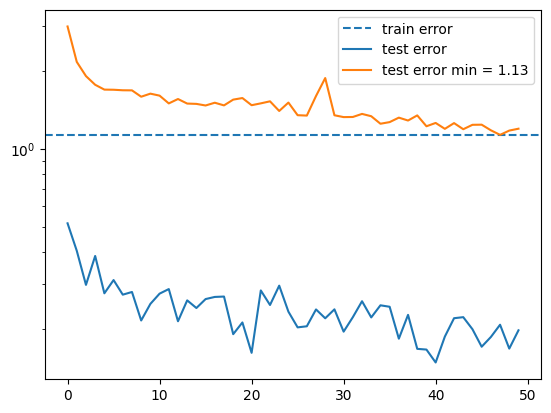

In [ ]:
fig, ax = plt.subplots(1)
training_vis = [torch.Tensor([t]).cpu().detach().numpy() for t in training_loss]
test_vis = [torch.Tensor([t]).cpu().detach().numpy() for t in test_loss]
test_min = min(test_vis)
ax.axhline(y=test_min,linestyle = '--') 
ax.set_yscale('log')
ax.plot(training_vis)
ax.plot(test_vis)
plt.legend(['train error', 'test error','test error min = %.2f' % test_min])

In [7]:
class Model(nn.Module):
      def __init__(self, in_channels=12):
        """
        Intermediate block in UNet
        Args:
          in_channels (int):  Number of input channels.
        """
        super(Model, self).__init__()
        self.early1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                             out_channels=32,
                                            kernel_size=7,padding=3), 
                                   nn.ELU())
        self.early2 = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                             out_channels=32,
                                            kernel_size=7,padding=3), 
                                   nn.ELU())
        self.conv1 = nn.Conv2d(in_channels=32, 
                                             out_channels=32,
                                            kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=32, 
                                             out_channels=2,
                                            kernel_size=3,padding=1)
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=2, 
                                             out_channels=32,
                                            kernel_size=1), nn.Sigmoid())
        self.convLast = nn.Conv2d(in_channels=32, 
                                             out_channels=2,
                                            kernel_size=3,padding=1)
        
        # two objects for separate training?
        self.stage1 = UNet()
        self.stage2 = UNet(in_channels=64)

      def forward(self, x):
        early1Out = self.early1(x)
        early2Out = self.early2(x)
        stage1Out = self.stage1(early1Out)  
        skip1 = self.conv1(stage1Out)
        conv2Out = self.conv2(stage1Out)
        out1 = x[:,:2] + conv2Out
        conv3Out = self.conv3(out1)
        multiplied = conv3Out * skip1
        added = multiplied + stage1Out
        concated = torch.cat((added,early2Out),dim=1)
        stage2Out = self.stage2(concated)
        out2 = self.convLast(stage2Out)
        return out1, out2
        # return out1

In [ ]:
# sample, fs = librosa.load('ido_piano.wav')
# n_fft = 512
# tens = torch.Tensor(sample)
# stftData =  torch.view_as_real(torch.stft(tens,n_fft=n_fft,
#                                           window=torch.hamming_window(n_fft),return_complex=True))
# stftData.shape
# frames = torch.randint(stftData.size(dim=1), (128,))
# next(iter(test_loader))
# next(iter(test_loader))
# !rmdir denoising2/mix_test/".ipynb_checkpoints"
# !rmdir denoising2/mix_train/".ipynb_checkpoints"
def compute_accuracy(net, testloader):
    loss1_test_fn = nn.L1Loss()
    loss2_test_fn = nn.L1Loss()
    net.eval()
    total = 0
    with torch.no_grad():
        for samples, labels in testloader:
            samples, labels = samples.to(device), labels.to(device)
            outputs1,outputs2 = net(samples)
            loss1_test = loss1_test_fn(outputs1,labels)
            loss2_test = loss2_test_fn(outputs2,labels)

            total += loss2_test.item()


    return total/(len(testloader)/len(samples))


In [ ]:
m = Model().to(device)
m.train()

optimizer = torch.optim.Adam(m.parameters(), lr=0.0005,betas=(0.7, 0.9))
loss1_fn =  nn.L1Loss()
training_loss = []
test_loss = []
loss2_fn =  nn.L1Loss()

EPOCHS = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = os.path.join('', 'model.pth')

for epoch in range(EPOCHS):
        m.train()
        for train_sample, train_label in train_loader:
          train_sample, train_label = train_sample.to(device), train_label.to(device)
        
          optimizer.zero_grad()
  #     forward pass
          out1, out2 = m(train_sample)
          out1, out2 = out1.to(device), out2.to(device)
          frame_size = train_label.size(dim=2)
  #     compute loss
          loss1 = loss1_fn(out1,train_label) 
          loss2 = loss2_fn(out2,train_label)
          loss = loss1 + loss2
  #     backpropagate gradients
          loss.backward()
          # loss1.backward()
  #     do gradient step
          optimizer.step()
        print("EPOCH %d, loss = %f" % (epoch, loss2))
        training_loss.append(loss2.item())
        loss_test = compute_accuracy(m,test_loader)
        test_loss.append(loss_test)
        if loss_test == min(test_loss):
          torch.save(m.cpu().state_dict(), path) # saving model
        m.cuda()

EPOCH 0, loss = 0.190939
EPOCH 1, loss = 0.144732
EPOCH 2, loss = 0.231016
EPOCH 3, loss = 0.139824
EPOCH 4, loss = 0.200346
EPOCH 5, loss = 0.260441
EPOCH 6, loss = 0.171617
EPOCH 7, loss = 0.217804
EPOCH 8, loss = 0.210956
EPOCH 9, loss = 0.202833
EPOCH 10, loss = 0.191237
EPOCH 11, loss = 0.243125
EPOCH 12, loss = 0.196262
EPOCH 13, loss = 0.141177
EPOCH 14, loss = 0.292003
EPOCH 15, loss = 0.157704
EPOCH 16, loss = 0.231333
EPOCH 17, loss = 0.199273
EPOCH 18, loss = 0.178254
EPOCH 19, loss = 0.152223
EPOCH 20, loss = 0.223090
EPOCH 21, loss = 0.174442
EPOCH 22, loss = 0.176398
EPOCH 23, loss = 0.174845
EPOCH 24, loss = 0.198759
EPOCH 25, loss = 0.195142
EPOCH 26, loss = 0.148866
EPOCH 27, loss = 0.179283
EPOCH 28, loss = 0.273338
EPOCH 29, loss = 0.190758
EPOCH 30, loss = 0.215230
EPOCH 31, loss = 0.189254
EPOCH 32, loss = 0.200253
EPOCH 33, loss = 0.170989
EPOCH 34, loss = 0.186097
EPOCH 35, loss = 0.196541
EPOCH 36, loss = 0.144298
EPOCH 37, loss = 0.118018
EPOCH 38, loss = 0.152

In [ ]:
rmdir denoising2/mix_test/.ipynb_checkpoints

rmdir: failed to remove '/content/denosing2/mix_test/.ipynb_checkpoints': No such file or directory


In [ ]:
# training_loss

In [ ]:
# import tensorflow as tf


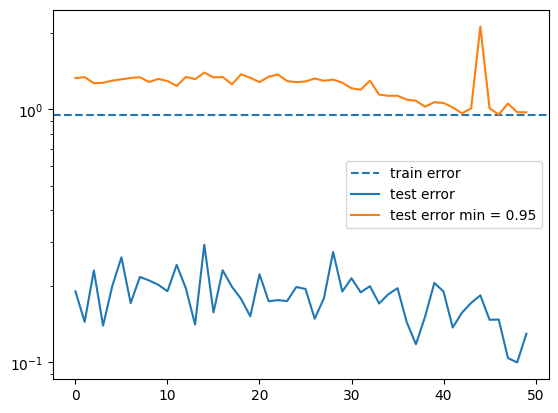

In [ ]:
fig, ax = plt.subplots(1)
training_vis = [torch.Tensor([t]).cpu().detach().numpy() for t in training_loss]
test_vis = [torch.Tensor([t]).cpu().detach().numpy() for t in test_loss]
test_min = min(test_vis)
ax.axhline(y=test_min,linestyle = '--') 
ax.set_yscale('log')
ax.plot(training_vis)
ax.plot(test_vis)
plt.legend(['train error', 'test error','test error min = %.2f' % test_min])

In [ ]:
# after training save model parameters
# torch.save(m.state_dict(), 'model.pth')
# test_loss

In [ ]:
def prepareSample(data,n_fft,fs):
        """
        convert to 12-channel STFT input 
        """
        toMono = np.sum(data,axis=1) if data.ndim>1 else data
        tens = torch.Tensor(toMono)
        stftData =  torch.view_as_real(torch.stft(tens,n_fft=n_fft,
                                                  window=torch.hamming_window(n_fft),return_complex=True))
        # add frames for power of two number
        toConcat = np.int_(2**(np.ceil(np.log2(stftData.size(dim=1)))) - stftData.size(dim=1))
        extraFrames = torch.zeros(stftData.size(dim=0),toConcat,stftData.size(dim=2))
        stftData = torch.cat((stftData,extraFrames),1)
        freqVect= np.arange(n_fft/2+1)*fs/n_fft
        numChannels = 12
      # newTens.shape = (channels,frames,freq)
        newTens = torch.zeros([numChannels, stftData.shape[1],stftData.shape[0]])
        newTens[:2,:,:]=stftData.permute(*torch.arange(stftData.ndim - 1, -1, -1))
        posEmbeds = torch.FloatTensor([[np.cos(2**i*np.pi*f/fs) for i in range(10)]
                                     for f in freqVect])
        fullSize = posEmbeds.T.unsqueeze(1).repeat(1, stftData.shape[1], 1)
        newTens[2:,:,:]=fullSize
#         need 1024 bins
        return newTens[:,:,:-1]

In [ ]:
import soundfile as sf
# to run model on new sample
model = smallModel()
model.load_state_dict(torch.load('model.pth'))
model.eval()
model.to('cpu')
# take random 
path= 'plane_rooster.ogg'
# sample, fs = librosa.load(path)
n_fft=2048
frames = prepareSample(noisy,n_fft,fs)
out = model(torch.unsqueeze(frames,0))
out = torch.squeeze(out,0)
out = out.permute(*torch.arange(out.ndim - 1, -1, -1))
complexOut = torch.view_as_complex(out.contiguous())
complexOut = torch.cat((complexOut,torch.zeros(1,complexOut.size(dim=1))),dim=0)
complexOut.shape
denoised = torch.istft(complexOut,n_fft=n_fft,window=torch.hamming_window(n_fft),
                       return_complex=False)[:len(noisy)]
denoised = denoised.detach().numpy()
# display.Audio(denoised,rate=fs)
DENOISED = 'denoised_'
sep = '/'
prefix, suffix = path[:path.rfind(sep)+1], path[path.rfind(sep)+1:]
out_path = os.path.join(prefix,DENOISED+suffix)
sf.write(out_path, denoised, fs)

In [ ]:
def SNR(data,n_fft,fs):
        """
        convert to 12-channel STFT input 
        """
        toMono = np.sum(data,axis=1) if data.ndim>1 else data
        tens = torch.Tensor(toMono)
        stftData =  torch.stft(tens,n_fft=n_fft,
                                                  window=torch.hamming_window(n_fft),return_complex=True)
        # add frames for power of two number
        toConcat = np.int_(2**(np.ceil(np.log2(stftData.size(dim=1)))) - stftData.size(dim=1))
        extraFrames = torch.zeros(stftData.size(dim=0),toConcat,stftData.size(dim=2))
        stftData = torch.cat((stftData,extraFrames),1)
        freqVect= np.arange(n_fft/2+1)*fs/n_fft
        numChannels = 12
      # newTens.shape = (channels,frames,freq)
        newTens = torch.zeros([numChannels, stftData.shape[1],stftData.shape[0]])
        newTens[:2,:,:]=stftData.permute(*torch.arange(stftData.ndim - 1, -1, -1))
        posEmbeds = torch.FloatTensor([[np.cos(2**i*np.pi*f/fs) for i in range(10)]
                                     for f in freqVect])
        fullSize = posEmbeds.T.unsqueeze(1).repeat(1, stftData.shape[1], 1)
        newTens[2:,:,:]=fullSize
#         need 1024 bins
        return newTens[:,:,:-1]

In [ ]:
# calculate SNR
def forSNR(path,n_fft):
  sample, _ = librosa.load(path)
  tens = torch.Tensor(sample)
  stftData =  torch.stft(tens,n_fft=n_fft, window=torch.hamming_window(n_fft),
                         return_complex=True)
  return stftData

def compute_segSNR(stft1, stft2):
  clean = torch.sum(torch.square(torch.abs(stft1)),dim=0)
  error = torch.sum(torch.square(torch.abs(stft1-stft2)),dim=0)
  divided = torch.div(clean,error)
  todB = torch.div(divided,20e-6)
  return torch.mul(torch.log10(todB),20)


paths= ['denoising2/Rooster_test/4-183487-A.ogg', 'denoised_test_model.wav',
        'denoised_test_simple.wav']
n_fft=2048
stfts = [forSNR(path,n_fft) for path in paths]
snr1 = compute_segSNR(stfts[0],stfts[1])
snr2 = compute_segSNR(stfts[0],stfts[2])


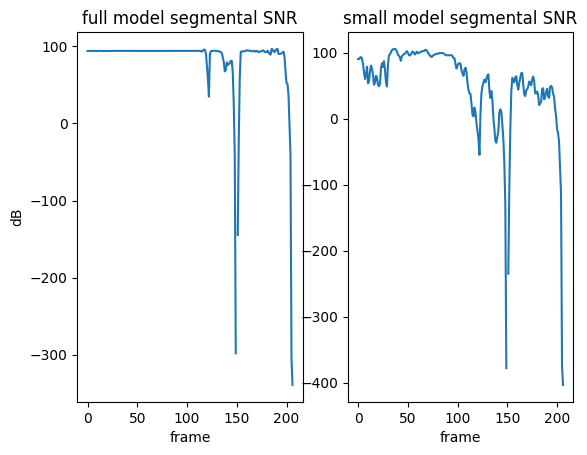

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(snr1)
#Plot the noisy signal and the segmental SNRs from the 4 methods. Let the x-axis denote frames and y-axis denote the SNR in dB
# plt.legend('avg segmental SNR = %.2f' % torch.mean(snr1))
ax1.set_title("full model segmental SNR")
ax1.set_xlabel("frame")
ax1.set_ylabel("dB")
# ax1.axhline(y=torch.mean(snr1),linestyle = '--', label='avg') 
# ax1.legend()

ax2.plot(snr2)
#Plot the noisy signal and the segmental SNRs from the 4 methods. Let the x-axis denote frames and y-axis denote the SNR in dB
# plt.legend('avg segmental SNR = %.2f' % torch.mean(snr2))
ax2.set_title("small model segmental SNR")
ax2.set_xlabel("frame")
# ax2.axhline(y=torch.mean(snr2),linestyle = '--', label='avg') 
# ax2.legend()
fig.show()

In [ ]:
model = smallModel()
model.load_state_dict(torch.load('model.pth'))
model.eval()

smallModel(
  (early1): Sequential(
    (0): Conv2d(12, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ELU(alpha=1.0)
  )
  (conv2): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (stage1): UNet(
    (block1): IBlock(
      (unit1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
      )
      (unit2): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
      )
      (unit3): Sequential(
        (0): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
      )
      (skip): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): IBlock(
        (unit1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
plane= '1-53467-A.ogg'
rooster= '2-71162-A.ogg'

plane_sample, fs = librosa.load(plane)
rooster_sample, _ = librosa.load(rooster)
# plane_sample = plane_sample * max(rooster_sample)/max(plane_sample)
noisy = plane_sample + rooster_sample
sf.write(path, noisy, fs)
